In [1]:
#!pip install gensim
#it acts as a bridge between python2 and pyhon3
from __future__ import absolute_import, division, print_function
# for word encoding
import codecs
#regex
import glob
#concurrency -- it is for multithreading(parallel processing)
import multiprocessing
#dealing with OS
import os
#pretty printing
import pprint
#regular exp
import re
#natural language library
import nltk
#word2vec
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
import pandas as pd
#visaluzation
import seaborn as sns

C:\Users\aradh\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#Step 1: process the data 
#clear data
#pretrained tokenizer
nltk.download('punkt')
#remove words like 'and', 'the' etc that does not matter
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aradh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aradh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
book_filename = ["C:/Users/aradh/Desktop/ML Projects/NLP Practice/GOT/A-Game-of-Thrones.txt"]
book_filename

['C:/Users/aradh/Desktop/ML Projects/NLP Practice/GOT/A-Game-of-Thrones.txt']

In [4]:
corpus_raw = u""
for books in book_filename:
    print("Reading '{0}'...".format(books))
    with codecs.open(books,"r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'C:/Users/aradh/Desktop/ML Projects/NLP Practice/GOT/A-Game-of-Thrones.txt'...
Corpus is now 1581253 characters long



In [5]:
corpus_raw

'\ufeffVersion History:\n2.0 - Reedited 4/25/10 by maelstrom385\n1.0 - Scanned 3/5/02 by sliph\n*missing appendix section\n\n\x0c\x0cBook One: A Song of Ice and Fire\nGeorge R.R. Martin\n\nPROLOGUE\n“We should start back,” Gared urged as the woods began to grow dark around them. “The\nwildlings are dead.”\n“Do the dead frighten you?” Ser Waymar Royce asked with just the hint of a smile.\nGared did not rise to the bait. He was an old man, past fifty, and he had seen the lordlings come\nand go. “Dead is dead,” he said. “We have no business with the dead.”\n“Are they dead?” Royce asked softly. “What proof have we?”\n“Will saw them,” Gared said. “If he says they are dead, that’s proof enough for me.”\nWill had known they would drag him into the quarrel sooner or later. He wished it had been later\nrather than sooner. “My mother told me that dead men sing no songs,” he put in.\n“My wet nurse said the same thing, Will,” Royce replied. “Never believe anything you hear at a\nwoman’s tit. There

In [6]:
#split the corpus into sentences-- 
#here tokenizer is a pretrained and it will convert the word/sentence into tokens
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
raw_sentences = tokenizer.tokenize(corpus_raw)
raw_sentences[0]

'\ufeffVersion History:\n2.0 - Reedited 4/25/10 by maelstrom385\n1.0 - Scanned 3/5/02 by sliph\n*missing appendix section\n\n\x0c\x0cBook One: A Song of Ice and Fire\nGeorge R.R.'

In [8]:
def sentence_to_wordlist(raw):
    #re.sub will remove every character other then a-z and A-Z.
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [9]:
#sentence where each word is tokenized
sentences = []
for raw in raw_sentences:
    if len(raw) >0:
        sentences.append(sentence_to_wordlist(raw))

In [10]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

“Dead is dead,” he said.
['Dead', 'is', 'dead', 'he', 'said']


In [11]:
token_count = sum(len(sentence) for sentence in sentences)
token_count

297553

In [12]:
#once we have vectors -- do below 3 steps:
#1. Distance, 2. Similaritty, 3. Ranking

#dimensionality of the resulting word vectors: 
# more dimension, more exprensive to train but more accurate (more generalized)
num_features = 300

# minimum word count threshold:
min_word_count = 3

# number of threads to run in parellel:
num_workers = multiprocessing.cpu_count()

#context window lengths: its the size of the block we are looking at once.
context_size = 7

#downsample settings for frequent words: 
downsampling = 1e-3

#seed for the RNG, to make the results repproducible.
seed = 1

In [13]:
book2vec = w2v.Word2Vec(
    sg = 1,
    seed = seed,
    workers = num_workers,
    size = num_features,
    min_count = min_word_count,
    window = context_size,
    sample = downsampling
)

In [14]:
book2vec.build_vocab(sentences)

In [15]:
print("Word2vec vocalubary length:", len(book2vec.wv.vocab))

Word2vec vocalubary length: 6291


In [16]:
#train the w2v
book2vec.train(sentences,total_examples=token_count, epochs=book2vec.iter)

1106762

In [17]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [18]:
book2vec.save(os.path.join("trained", "book2vec.w2v"))

Explore the trained model

In [19]:
book2vec= w2v.Word2Vec.load(os.path.join("trained","book2vec.w2v"))

In [20]:
#Compress the word vector into 2d space
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)


In [21]:
all_word_vectors_matrix = book2vec.wv.syn0

In [23]:
#train tSNE

all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [24]:
points = pd.DataFrame(
    [
        (word,coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[book2vec.wv.vocab[word].index])
            for word in book2vec.wv.vocab
        ]
    ],
    columns = ["word", "x","y"]
)

In [25]:
points.head(10)

,word,x,y
0,by,-4.946210,2.794540
1,missing,1.214496,-2.625356
2,One,-1.516732,0.138047
3,A,-2.332478,1.086658
4,of,-5.354036,6.035696
5,Ice,0.260341,1.498797
6,and,-3.923152,7.823374
7,Fire,-3.050089,1.044855
8,We,-0.253342,-4.346504
9,should,-1.353674,-6.041966


In [26]:
sns.set_context("poster")

In [80]:
points.iloc[:,1]

0      -4.946210
1       1.214496
2      -1.516732
3      -2.332478
4      -5.354036
5       0.260341
6      -3.923152
7      -3.050089
8      -0.253342
9      -1.353674
10     -0.896204
11      1.084803
12     -1.293078
13     -2.369256
14      0.983904
15     -5.675358
16      4.531655
17      0.782524
18      0.861873
19      3.841109
20     -2.280933
21     -0.591704
22     -4.795694
23     -5.171295
24     -2.938111
25     -2.650983
26      2.051718
27     -1.461209
28     -0.857579
29     -0.679653
          ...   
6261   -1.973595
6262   -2.114244
6263   -4.032429
6264   -2.931582
6265   -2.919133
6266   -3.104619
6267   -0.159674
6268    2.210356
6269   -3.170993
6270   -5.002369
6271   -0.958451
6272   -3.409629
6273   -3.532009
6274   -2.641013
6275   -6.036045
6276   -5.361296
6277   -5.395163
6278   -1.455523
6279   -2.101175
6280   -3.615892
6281    1.988755
6282   -4.325670
6283   -0.349311
6284   -0.226651
6285   -1.726106
6286   -1.936730
6287   -3.165457
6288   -5.6713

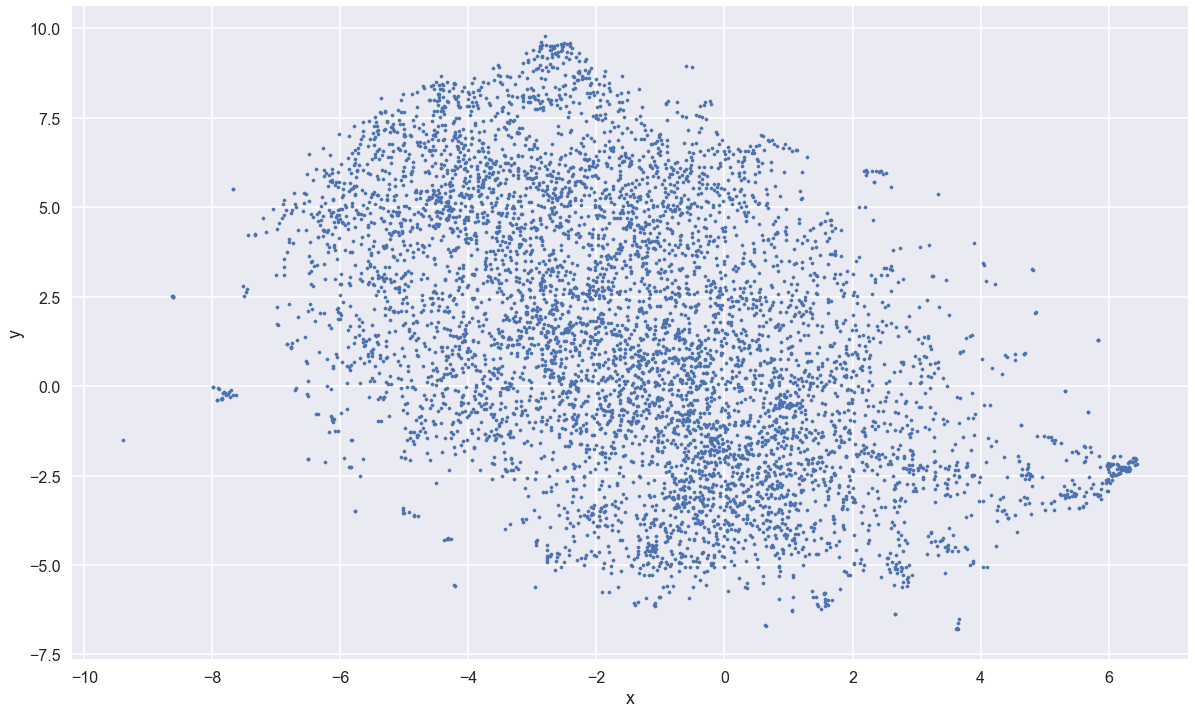

In [84]:
%matplotlib inline
points.plot.scatter("x","y", s=10, figsize = (20,12))

In [92]:
    def plot_region (x_bounds, y_bounds):
        slice = points[
            (x_bounds[0] <= points.x)&
            (points.x <= x_bounds[1])&
            (y_bounds[0] <= points.y)&
            (points.y <= y_bounds[1])
        ]
        
        ax = slice.plot.scatter("x","y",s = 35, figsize = (10,8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y+0.005, point.word )

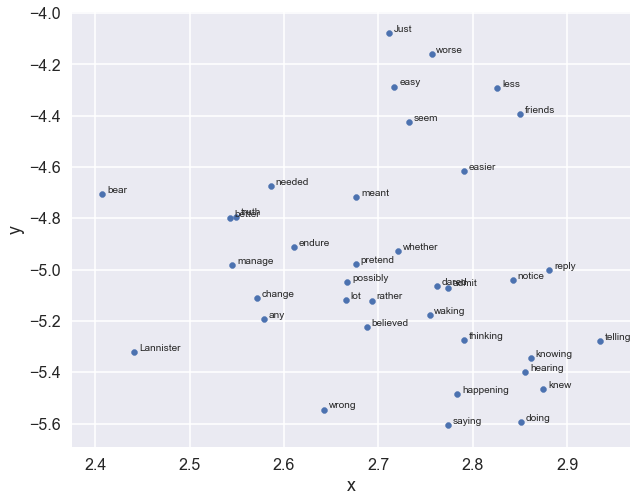

In [96]:
plot_region(x_bounds=(2.3, 3.0),y_bounds=(-6.0,-4.0))

In [40]:
book2vec.most_similar("Robert")

[('Aerys', 0.751539409160614),
 ('Baratheon', 0.7288987636566162),
 ('widow', 0.7242746353149414),
 ('nephew', 0.7106969356536865),
 ('friend', 0.7019293308258057),
 ('justice', 0.7017366886138916),
 ('appointment', 0.6989295482635498),
 ('distaste', 0.6985488533973694),
 ('deserter', 0.6975448131561279),
 ('Joffrey', 0.6969641447067261)]

In [64]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = book2vec.most_similar_cosmul(
        positive = [end2, start1],
        negative = [end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [67]:
nearest_similarity_cosmul("Robert", "Joffrey", "Sansa")

Robert is related to Joffrey, as Lyanna is related to Sansa


'Lyanna'